# Load workspace

In [8]:
load("DESeq2_trimmed_macrogen_data_alone_blebb.RData")

# Load libraries

In [1]:
suppressPackageStartupMessages({library(Rsubread)
                                library(DESeq2)
                                library("dplyr")
                                library("ggplot2")
                                library("pheatmap")
                                library("RColorBrewer")
                                library(AnnotationDbi)
                                library(org.Dr.eg.db)
                                library(repr)
                                library(topGO)
                                library(GOstats)
                               })

library(GOstats)


groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.



In [2]:
# set size of plot windows
options(repr.plot.width=12, repr.plot.height=10)

Did not remove duplicated reads although there are UMIs general advice from Anika is that these haven't been useful in bulk as they saturate quickly. #may check eventually if this is the case here when we have low read recover. Reads were mapped to danrer11 with STAR. Here following the RNA-seq workflow from bioconductor: https://www.bioconductor.org/packages/devel/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html

# Rsubread
First create count matrix with Rsubread: https://bioconductor.org/packages/3.12/bioc/vignettes/Rsubread/inst/doc/Rsubread.pdf

ThefeatureCountsfunction is a general-purpose read summarization function thatassigns mapped reads (RNA-seq or gDNA-seq reads) to genomic features such as genes,exons, promoters, gene bodies and genomic windows.This function takes as input a set of files that contain read mapping results and anannotation file that includes genomic features. It automatically detects the format ofinput read files (supported formats include SAM and BAM). Input reads can be name-sorted or location-sorted. Users do not need to resort the reads before feeding them to featureCounts.

In [3]:
bamfiles<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped_trimmed", pattern= "*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles2<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "Blebb[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles3<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "DMSO[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles4<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "cmV[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles5<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "cmC[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles2
bamfiles3

[1] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm1/Blebbicm1.Aligned.out.bam"
[2] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm2/Blebbicm2.Aligned.out.bam"
[3] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm3/Blebbicm3.Aligned.out.bam"

[1] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm1/DMSOcm1.Aligned.out.bam"
[2] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm2/DMSOcm2.Aligned.out.bam"
[3] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm3/DMSOcm3.Aligned.out.bam"

In [4]:
bamfiles_all<-c(bamfiles2, bamfiles3)
bamfiles_all

[1] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm1/Blebbicm1.Aligned.out.bam"
[2] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm2/Blebbicm2.Aligned.out.bam"
[3] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm3/Blebbicm3.Aligned.out.bam"
[4] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm1/DMSOcm1.Aligned.out.bam"    
[5] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm2/DMSOcm2.Aligned.out.bam"    
[6] "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm3/DMSOcm3.Aligned.out.bam"

In [5]:
mycounts <- featureCounts(bamfiles_all, annot.ext="/fast/AG_Ohler/Alison/reference_genomes/danrer11/Danio_rerio.GRCz11.100.gtf", isGTFAnnotationFile=TRUE, isPairedEnd=FALSE, countMultiMappingReads = FALSE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.3.9

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 6 BAM files                                      ||
||                                                                            ||
||                           Blebbicm1.Aligned.out.bam                        ||
||                           Blebbicm2.Aligned.out.bam                        ||
||                           Blebbicm3.Aligned.out.ba

## Import count matrix into DESeq2

Now import count matrix into DESeq2 with DESeqDataSetFromMatrix (see 3.2 Starting from count matrices) Batches were given by Anne Merks. Could be divided based on embryonic clutches but this is unbalanced for the second expt because different embryonic lines were used, and also when the experiment was performed. Experiment batches won't be used for selection of DE genes so can't be included in design formula. Decide whether it is better to analyse them separately or all together (first inclination is together, to allow more borrowed information). Looks like analysising separately is better - or matches the macrogen analysis better. Perhaps variance is flattened a bit when all together.

In [6]:
countData<-mycounts$counts
allsamples<-read.csv("/fast/AG_Ohler/Alison/panakova_CM_RNAseq/mapped_trimmed_samplesheet_batches_macrogen.txt", sep="\t", header=TRUE)
rbind(allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="bleb")),],allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="dmso")),] )
colData<-rbind(allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="bleb")),],allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="dmso")),] )
#colData<-allsamples[allsamples$expt=="expt1",]
#colData

,path,samplename,condition,expt
,<chr>,<chr>,<chr>,<chr>
23,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm1/Blebbicm1.Aligned.out.bam,Blebbicm1,bleb,expt1
24,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm2/Blebbicm2.Aligned.out.bam,Blebbicm2,bleb,expt1
25,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/Blebbicm3/Blebbicm3.Aligned.out.bam,Blebbicm3,bleb,expt1
26,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm1/DMSOcm1.Aligned.out.bam,DMSOcm1,dmso,expt1
27,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm2/DMSOcm2.Aligned.out.bam,DMSOcm2,dmso,expt1
28,/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped/DMSOcm3/DMSOcm3.Aligned.out.bam,DMSOcm3,dmso,expt1


In [7]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                                 colData = colData,
#                                 design = ~ condition + batch)
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


# Exploratory analysis and visualization

## Prefiltering the dataset

Removing rows with no counts or only a single count across all samples. NB may come back and adjust this


In [8]:
nrow(dds)

[1] 32520

In [9]:
# check that col data matches bam file names
dds
colData(dds)

class: DESeqDataSet 
dim: 32520 6 
metadata(1): version
assays(1): counts
rownames(32520): ENSDARG00000102141 ENSDARG00000102123 ...
  ENSDARG00000101098 ENSDARG00000103574
rowData names(0):
colnames(6): Blebbicm1.Aligned.out.bam Blebbicm2.Aligned.out.bam ...
  DMSOcm2.Aligned.out.bam DMSOcm3.Aligned.out.bam
colData names(4): path samplename condition expt

DataFrame with 6 rows and 4 columns
                                            path  samplename condition
                                     <character> <character>  <factor>
Blebbicm1.Aligned.out.bam /fast/AG_Ohler/Aliso..   Blebbicm1      bleb
Blebbicm2.Aligned.out.bam /fast/AG_Ohler/Aliso..   Blebbicm2      bleb
Blebbicm3.Aligned.out.bam /fast/AG_Ohler/Aliso..   Blebbicm3      bleb
DMSOcm1.Aligned.out.bam   /fast/AG_Ohler/Aliso..     DMSOcm1      dmso
DMSOcm2.Aligned.out.bam   /fast/AG_Ohler/Aliso..     DMSOcm2      dmso
DMSOcm3.Aligned.out.bam   /fast/AG_Ohler/Aliso..     DMSOcm3      dmso
                                 expt
                          <character>
Blebbicm1.Aligned.out.bam       expt1
Blebbicm2.Aligned.out.bam       expt1
Blebbicm3.Aligned.out.bam       expt1
DMSOcm1.Aligned.out.bam         expt1
DMSOcm2.Aligned.out.bam         expt1
DMSOcm3.Aligned.out.bam         expt1

In [10]:
keep <- rowSums(counts(dds)) > 1
# at least 3 samples with a count of 10 or higher
#keep <- rowSums(counts(dds) >= 1) >= 3
dds <- dds[keep,]
nrow(dds)

[1] 28795

## The variance stabilizing transformation and the rlog

Normalization here is aimed to stabilise the variance across the mean, for the purposes of plotting. If you just take counts, the largest counts have the highest absolute variance. If you take log2+1 of counts, the smaller counts will be over-represented in the variance. DESeq2 has two methods to deal with this now - VST and rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). => Use rlog here, but it takes longer to compute

In [11]:
vsd <- vst(dds, blind = FALSE) # can try blind=TRUE for completely unsupervised
head(assay(vsd), 3)

,Blebbicm1.Aligned.out.bam,Blebbicm2.Aligned.out.bam,Blebbicm3.Aligned.out.bam,DMSOcm1.Aligned.out.bam,DMSOcm2.Aligned.out.bam,DMSOcm3.Aligned.out.bam
ENSDARG00000102141,8.332806,8.682151,8.976846,8.680997,8.712285,8.924096
ENSDARG00000102123,7.950635,7.841385,8.138328,7.735102,7.581956,7.556102
ENSDARG00000114503,8.860637,8.155099,9.200262,8.386144,8.521460,8.496595


In [12]:
rld <- rlog(dds, blind = FALSE) # can try blind=TRUE for completely unsupervised
head(assay(rld), 3)

,Blebbicm1.Aligned.out.bam,Blebbicm2.Aligned.out.bam,Blebbicm3.Aligned.out.bam,DMSOcm1.Aligned.out.bam,DMSOcm2.Aligned.out.bam,DMSOcm3.Aligned.out.bam
ENSDARG00000102141,7.998542,8.303790,8.558313,8.302664,8.329965,8.513313
ENSDARG00000102123,7.166316,7.065392,7.340744,6.964652,6.816540,6.792679
ENSDARG00000114503,8.408339,7.785126,8.700919,7.991726,8.112313,8.090440


Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


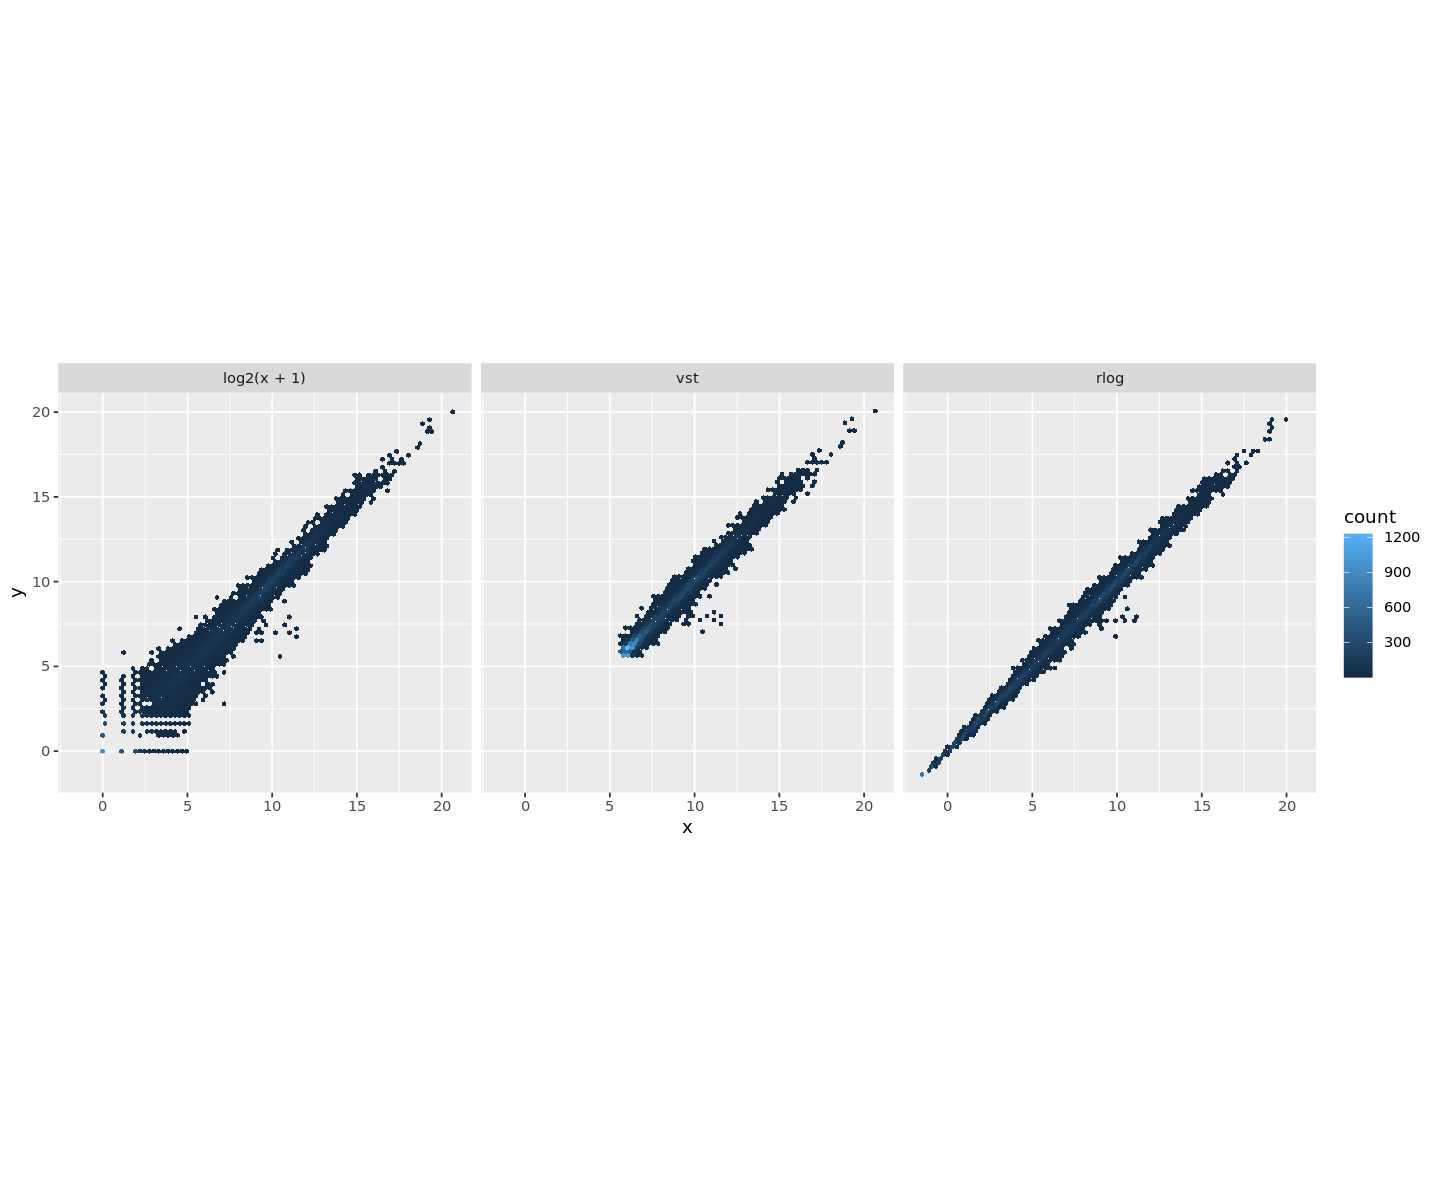

In [13]:
library("dplyr")
library("ggplot2")

dds <- estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "vst", "rlog")
df$transformation <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

In [14]:
sampleDists <- dist(t(assay(vsd)))
#sampleDists

In [15]:
library("pheatmap")
library("RColorBrewer")

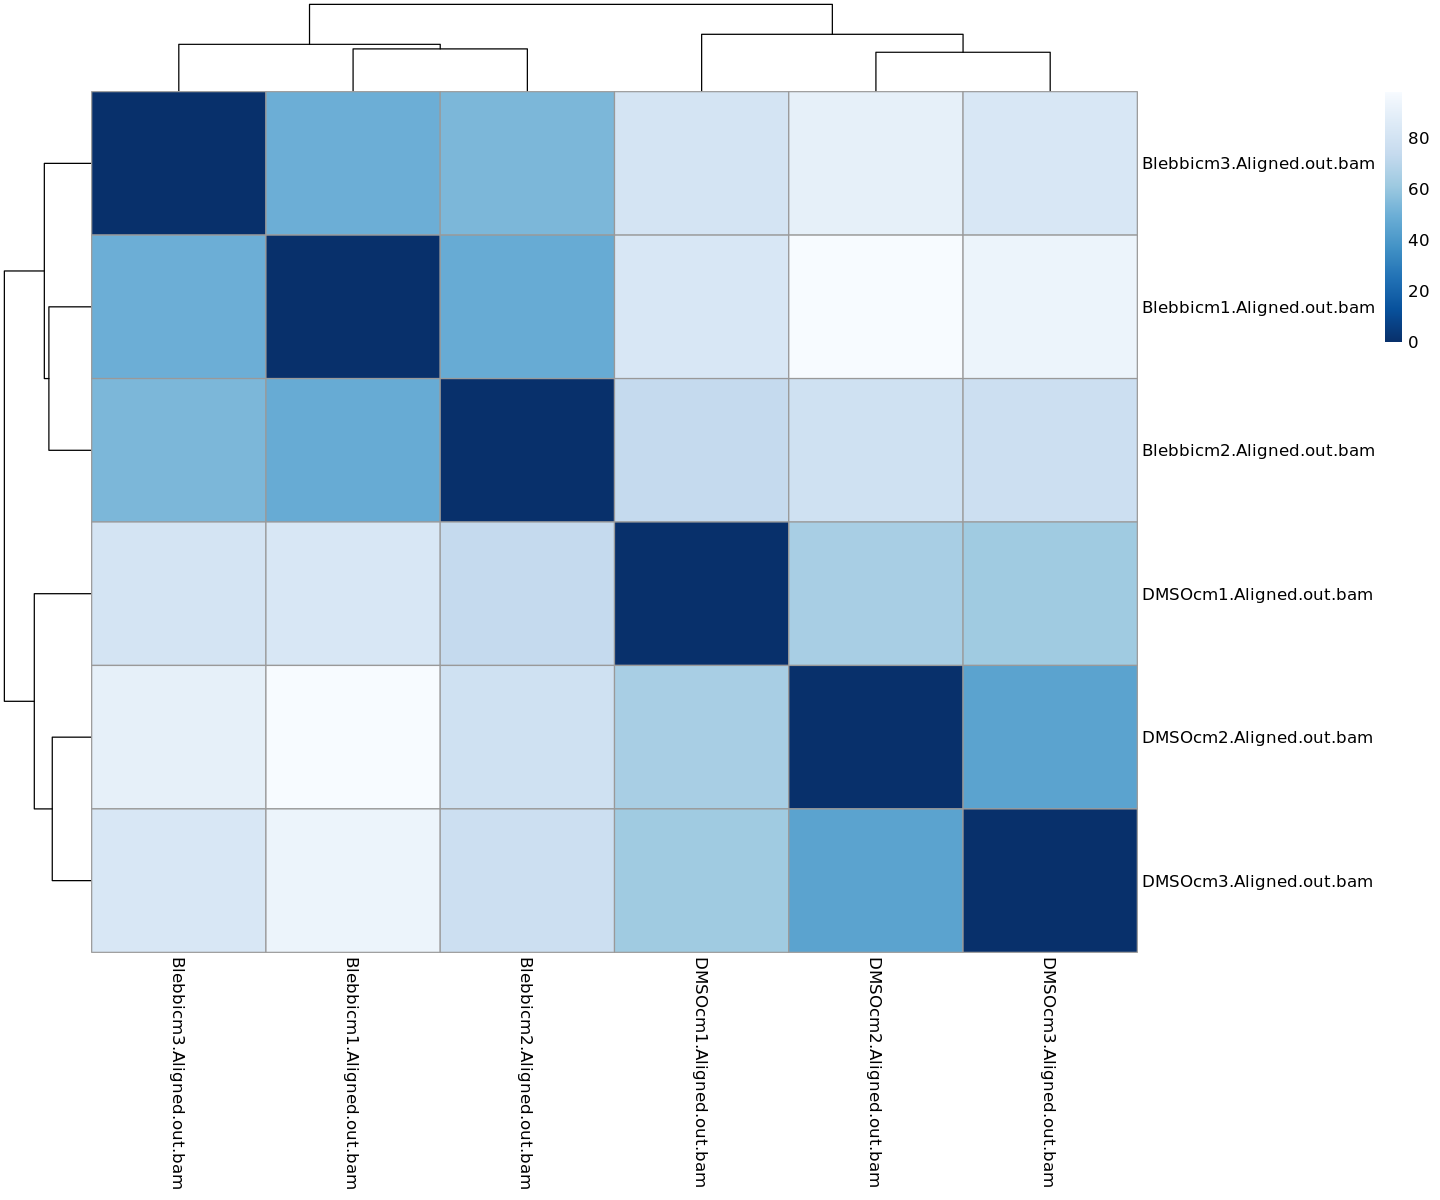

In [16]:
sampleDistMatrix <- as.matrix( sampleDists )
#rownames(sampleDistMatrix) <- paste( vsd$dex, vsd$cell, sep = " - " )
#colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

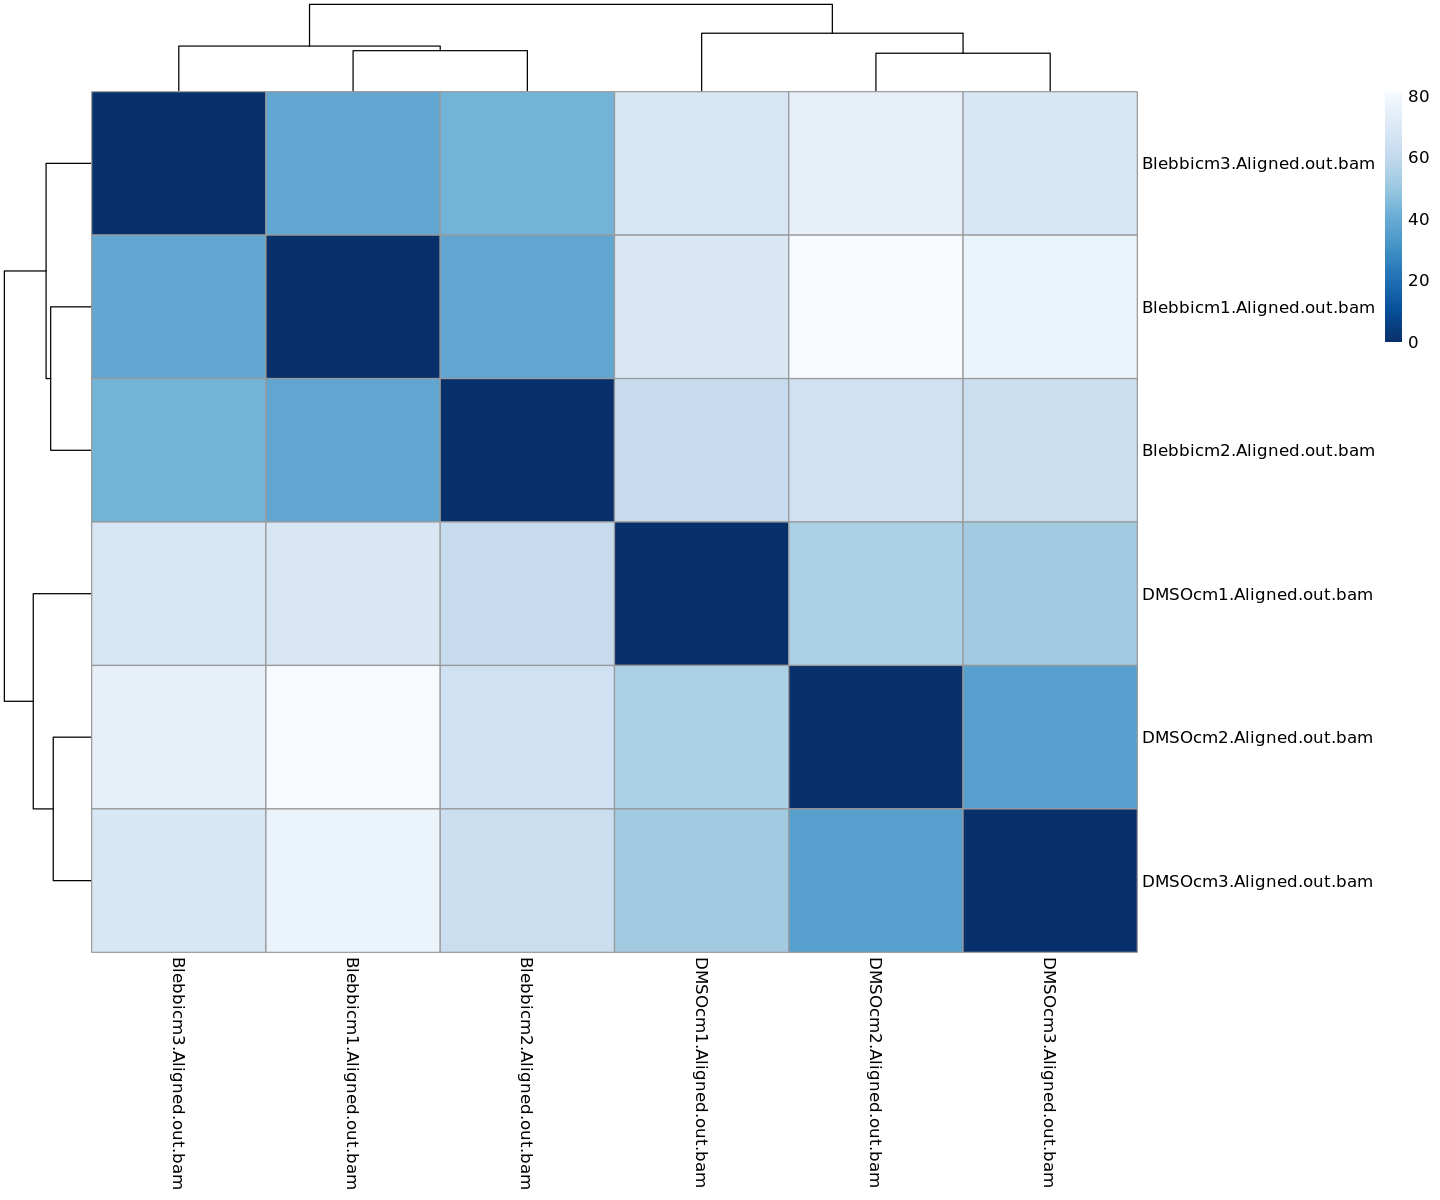

In [17]:
sampleDists_rld <- dist(t(assay(rld)))
sampleDistMatrix_rld <- as.matrix( sampleDists_rld )
#rownames(sampleDistMatrix) <- paste( vsd$dex, vsd$cell, sep = " - " )
#colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix_rld,
         clustering_distance_rows = sampleDists_rld,
         clustering_distance_cols = sampleDists_rld,
         col = colors)

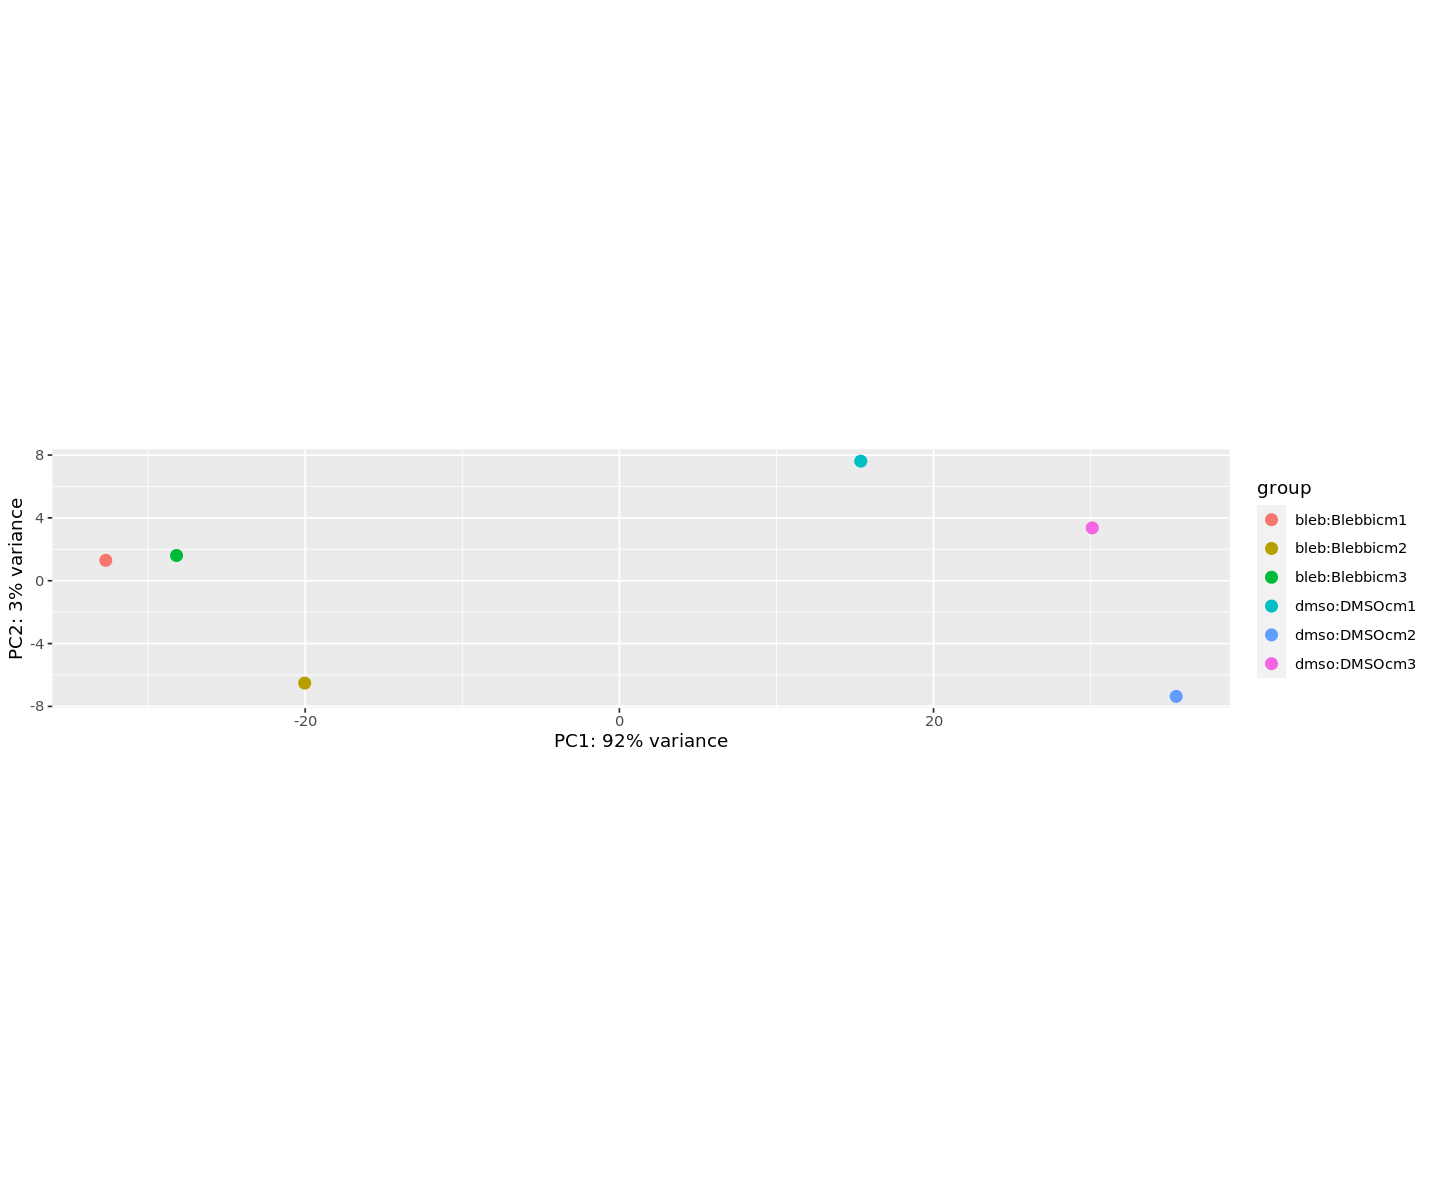

In [18]:
plotPCA(vsd, intgroup=c("condition","samplename"))
# add sample names

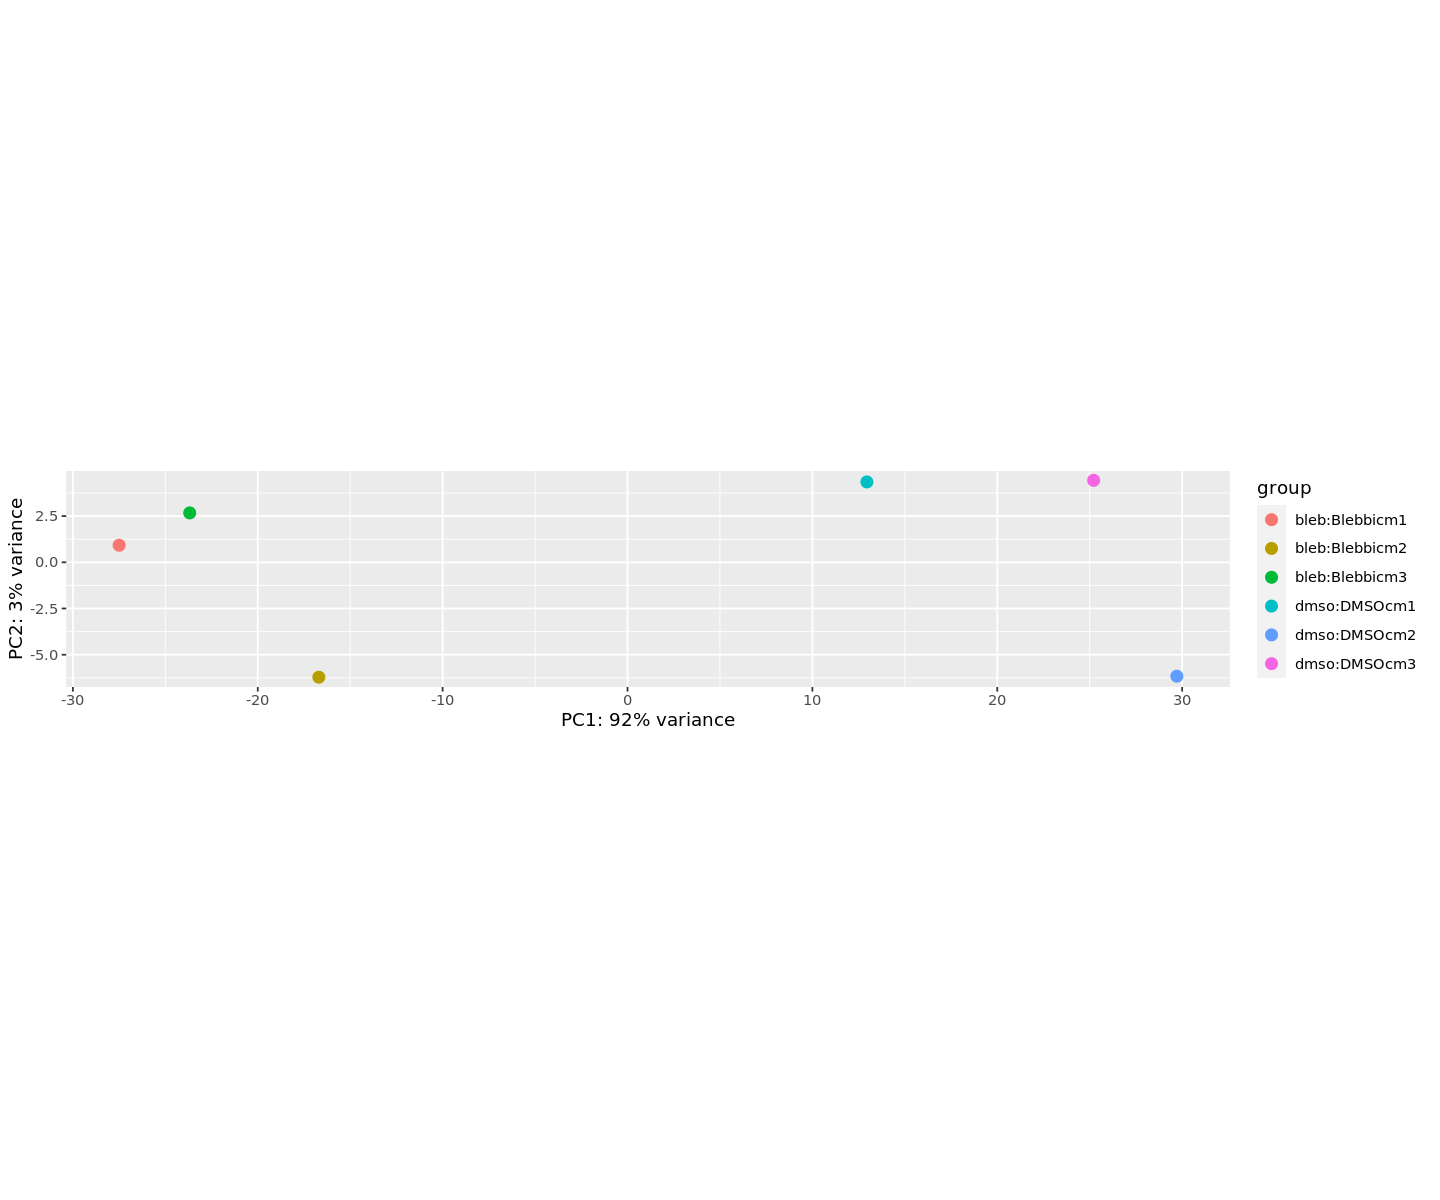

In [19]:
plotPCA(rld, intgroup=c("condition","samplename"))

## Differential expression analysis

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq:

This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing ?DESeq. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values for each gene, and fitting a generalized linear model.

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

In [20]:
dds <- DESeq(dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [21]:
res <- results(dds, contrast=c("condition","bleb","dmso"))
res

log2 fold change (MLE): condition bleb vs dmso 
Wald test p-value: condition bleb vs dmso 
DataFrame with 28795 rows and 6 columns
                    baseMean log2FoldChange     lfcSE       stat    pvalue
                   <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSDARG00000102141  327.3729     -0.1105004  0.258183  -0.427993  0.668656
ENSDARG00000102123  132.9860      0.5746041  0.267440   2.148538  0.031671
ENSDARG00000114503  302.8150      0.4350724  0.314304   1.384242  0.166284
ENSDARG00000115971   16.1526     -0.4630816  0.638751  -0.724980  0.468464
ENSDARG00000098311  193.5766      0.0297647  0.265756   0.112000  0.910823
...                      ...            ...       ...        ...       ...
ENSDARG00000101464   2.72873      0.4404137  1.463500  0.3009319  0.763466
ENSDARG00000103580 199.86020      0.3093892  0.226208  1.3677216  0.171399
ENSDARG00000104659 498.29589      0.0143792  0.187435  0.0767156  0.938850
ENSDARG00000101098  62.78660     -0.0452082 

### select significant genes between bleb and dmso

In [22]:
sum(res$padj < 0.05, na.rm=TRUE)
resSig <- subset(res, padj < 0.05)
resSig <- subset(resSig, abs(log2FoldChange) > 1)
dim(resSig)
sum(resSig$log2FoldChange > 1, na.rm=TRUE)
sum(resSig$log2FoldChange < -1, na.rm=TRUE)

[1] 1979

[1] 1161    6

[1] 986

[1] 175

In [23]:
head(resSig[ order(-resSig$log2FoldChange), ])

log2 fold change (MLE): condition bleb vs dmso 
Wald test p-value: condition bleb vs dmso 
DataFrame with 6 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSDARG00000105585    21.5419        5.14232  0.967783   5.31350 1.07537e-07
ENSDARG00000097932    16.9227        4.45480  0.845180   5.27083 1.35812e-07
ENSDARG00000104823   912.7061        4.22847  0.351630  12.02535 2.61482e-33
ENSDARG00000002768 59173.0971        4.22439  0.624220   6.76746 1.31060e-11
ENSDARG00000029710   249.4236        4.15605  0.400537  10.37622 3.18136e-25
ENSDARG00000087258    57.8288        4.14974  0.510322   8.13161 4.23621e-16
                          padj
                     <numeric>
ENSDARG00000105585 3.85210e-06
ENSDARG00000097932 4.78930e-06
ENSDARG00000104823 2.80996e-30
ENSDARG00000002768 7.23236e-10
ENSDARG00000029710 7.46632e-23
ENSDARG00000087258 3.26396e-14

### annotate genes with gene names

In [24]:
library(AnnotationDbi)
library(org.Dr.eg.db)

In [25]:
columns(org.Dr.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "ONTOLOGY"     "ONTOLOGYALL" 
[16] "PATH"         "PFAM"         "PMID"         "PROSITE"      "REFSEQ"      
[21] "SYMBOL"       "UNIGENE"      "UNIPROT"      "ZFIN"

In [26]:
ens.str <- substr(rownames(res), 1, length(rownames(res)))
res$symbol <- mapIds(org.Dr.eg.db,
                     keys=ens.str,
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Dr.eg.db,
                     keys=ens.str,
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [27]:
resSig <- subset(res, padj < 0.05)
resSig <- subset(resSig, abs(log2FoldChange) > 1)

## plot heat maps with top and bottom DE genes

In [28]:
#select top and bottom most differential genes
topBotDEGenes<-rbind(head(resSig[ order(-resSig$log2FoldChange), ], 20),
                       head(resSig[ order(resSig$log2FoldChange), ], 20))
#head(topBotDEGenes, 20)

In [29]:
# select blab and dmso samples
blebdmso_samples<-colData(vsd)[vsd$condition == "bleb" | vsd$condition == "dmso",]

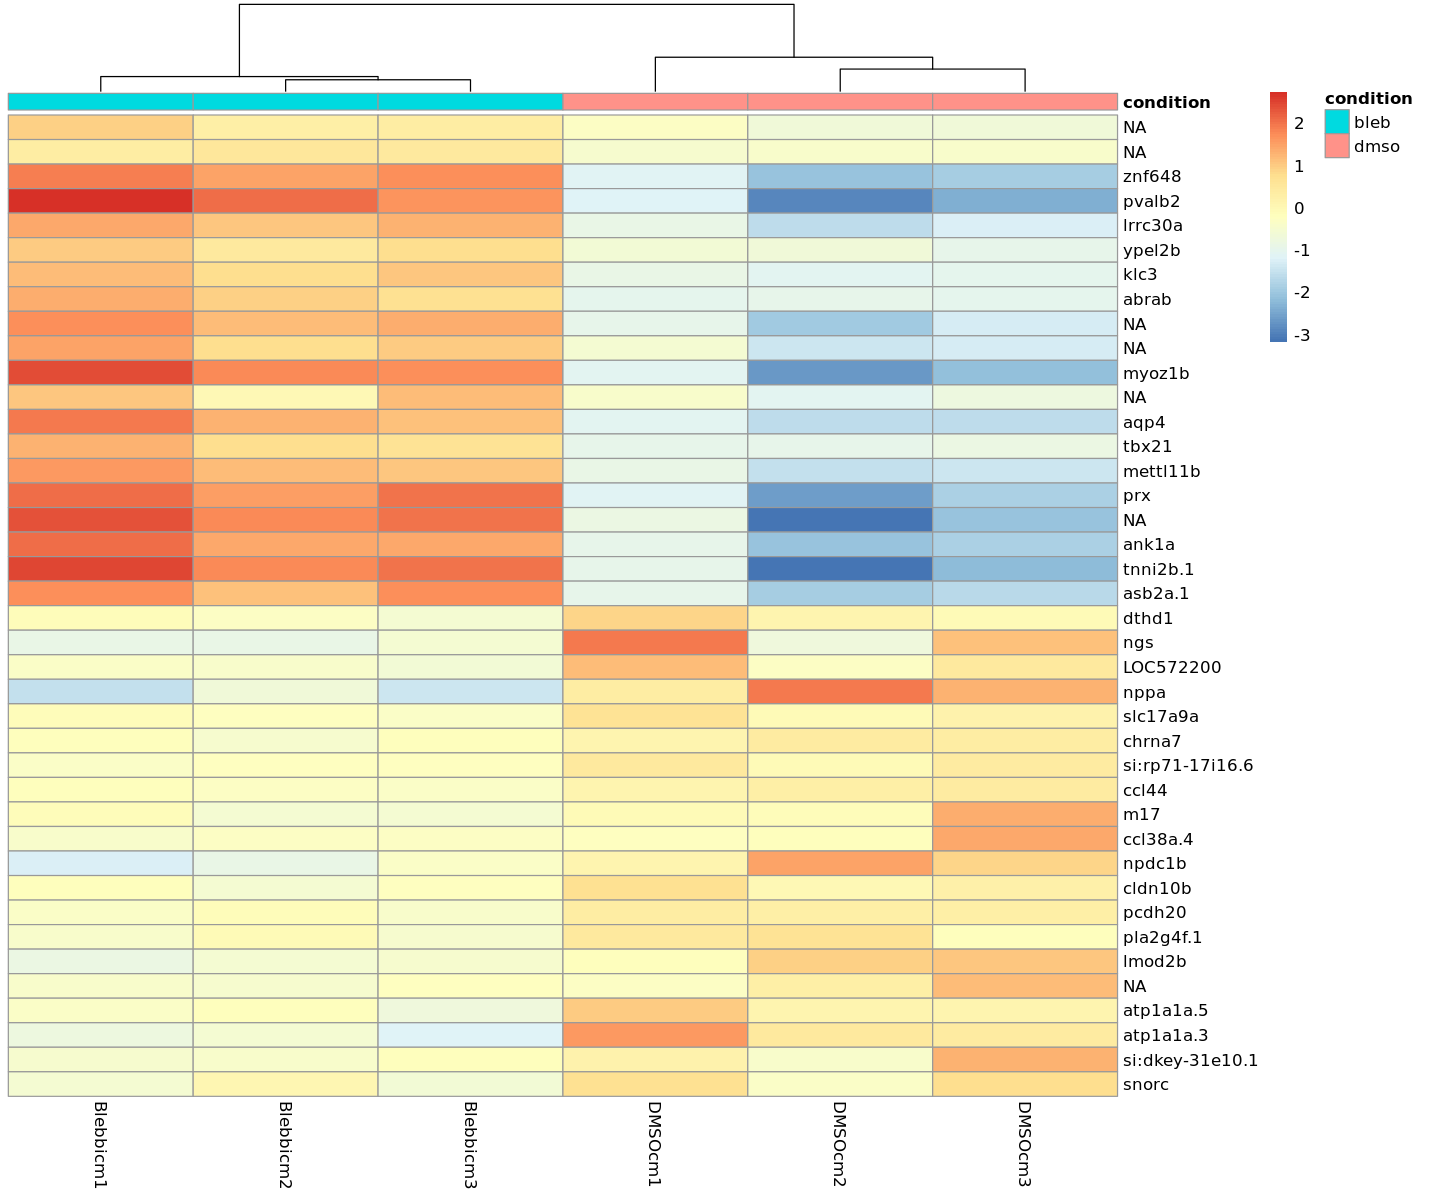

In [30]:
mat<-(assay(vsd)[rownames(topBotDEGenes), rownames(blebdmso_samples)])
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[rownames(blebdmso_samples), "condition", drop=FALSE]) # drop=FALSE allows you to select just one column of dataframe
library(pheatmap)
labels_col = c(colData(vsd)[rownames(blebdmso_samples), "samplename"])
labels_row = c(topBotDEGenes$symbol)
pheatmap(mat, annotation_col = anno, labels_col = labels_col, labels_row = labels_row, cluster_rows=FALSE)
#pheatmap(mat, annotation_col = anno, labels_col = labels_col, labels_row = labels_row, cluster_rows=FALSE, filename = "deseq2_macrogenonlybleb_outputs/topbot15heatmap_bleb_dmso.png")
pheatmap(mat, annotation_col = anno, labels_col = labels_col, labels_row = labels_row, cluster_rows=FALSE, filename = "deseq2_macrogenonlybleb_outputs/topbot15heatmap_bleb_dmso.pdf")

### Heatmap with all DE genes between samples

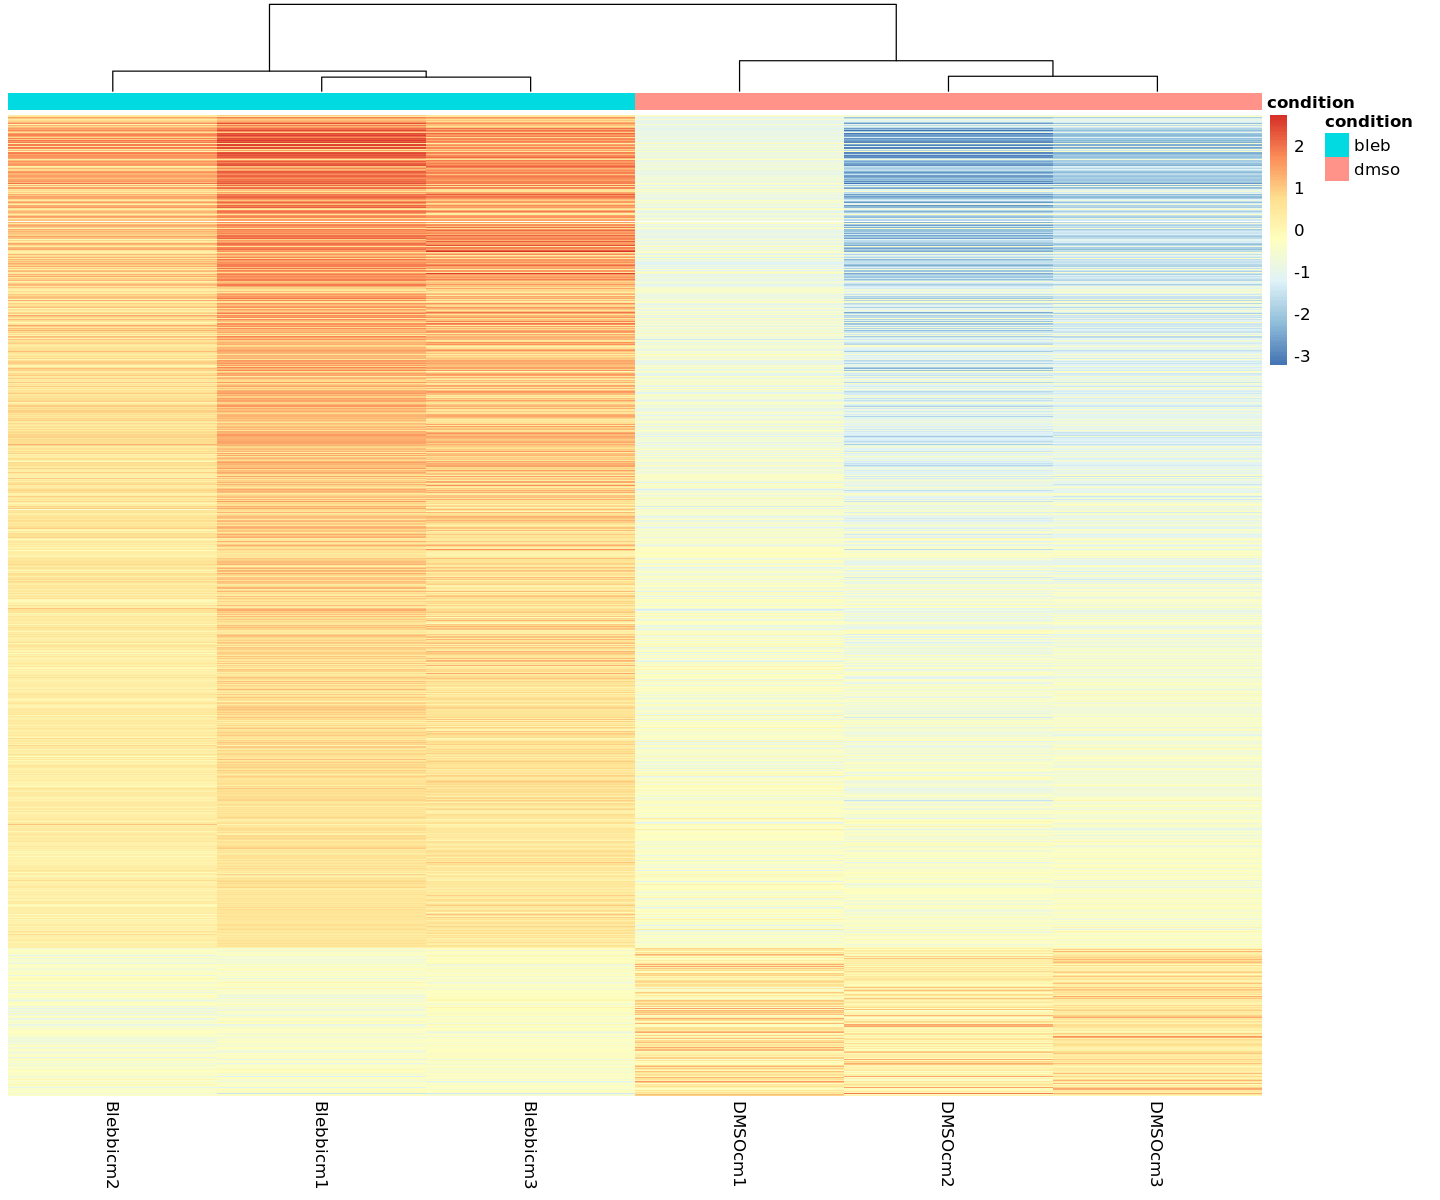

In [31]:
allDEGenes<-resSig[ order(-resSig$log2FoldChange), ]

matall<-(assay(vsd)[rownames(allDEGenes), rownames(blebdmso_samples)])
matall  <- matall - rowMeans(matall)
anno <- as.data.frame(colData(vsd)[rownames(blebdmso_samples), "condition", drop=FALSE]) # drop=FALSE allows you to select just one column of dataframe
library(pheatmap)
labels_col = c(colData(vsd)[rownames(blebdmso_samples), "samplename"])
pheatmap(matall, annotation_col = anno, labels_col = labels_col, cluster_rows=FALSE, show_rownames=FALSE)
pheatmap(matall, annotation_col = anno, labels_col = labels_col, cluster_rows=FALSE, show_rownames=FALSE, filename = "deseq2_macrogenonlybleb_outputs/allDEpadj0.05heatmap_bleb_dmso.pdf")

## volcano plot

[1] 20418     8

Warning message:
“Removed 20398 rows containing missing values (geom_text).”


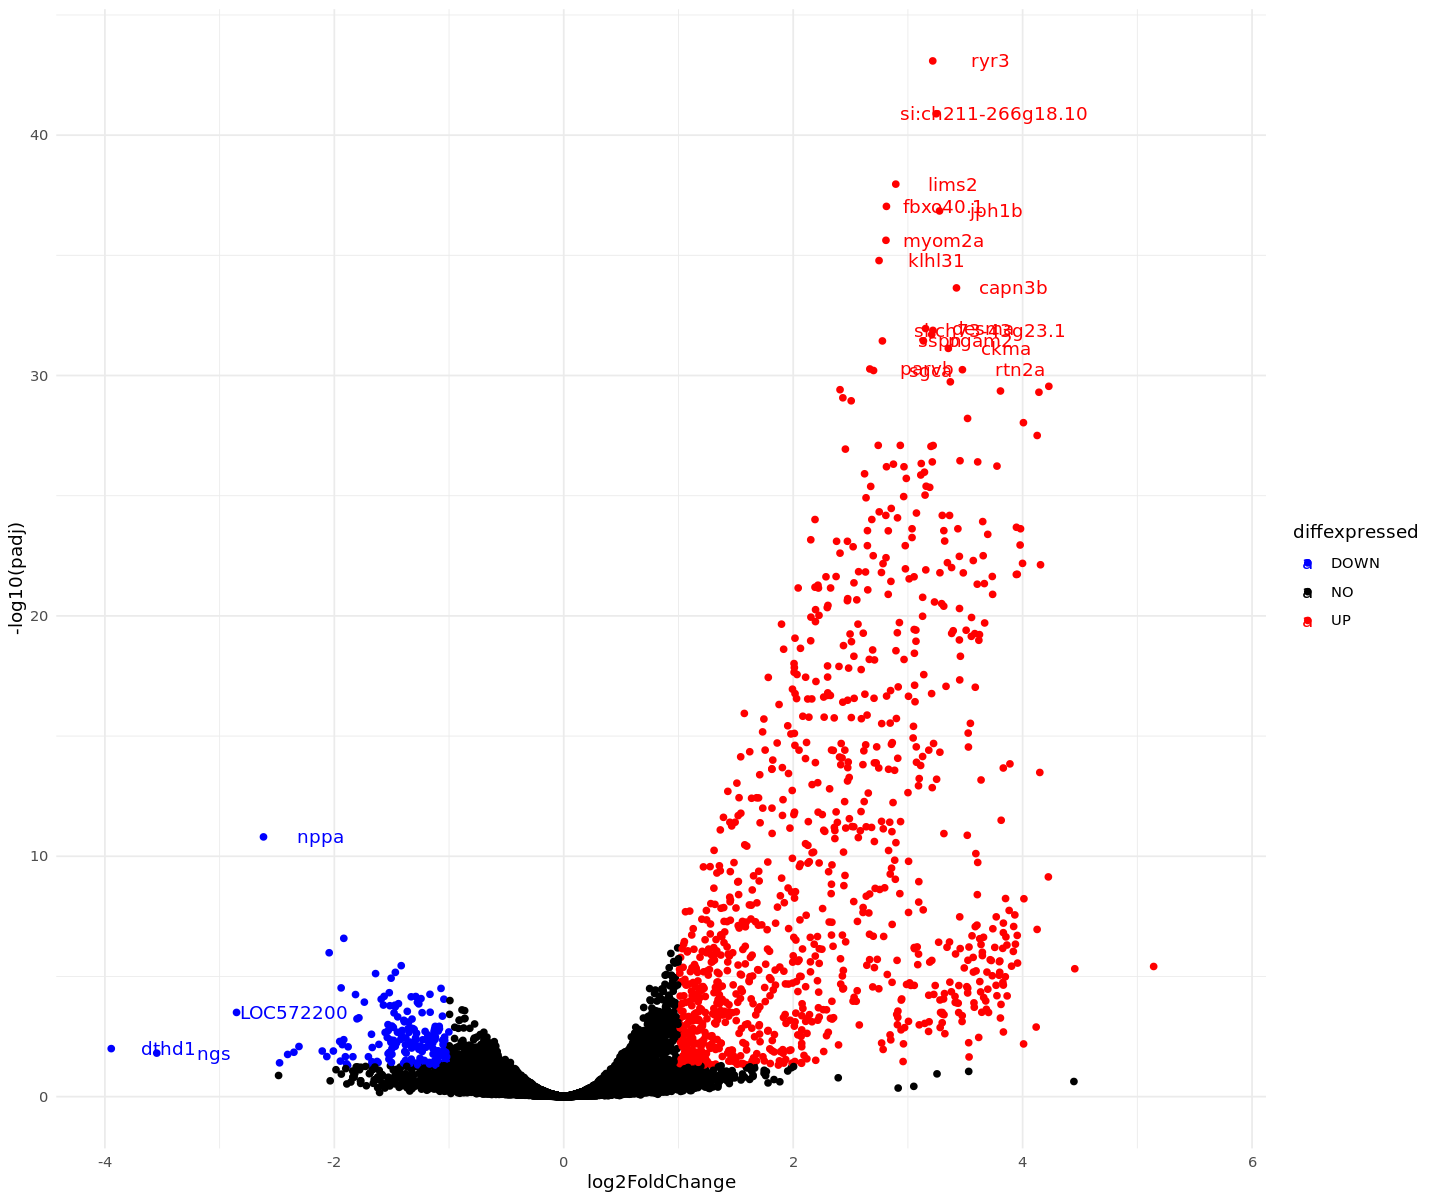

Saving 6.67 x 6.67 in image

Warning message:
“Removed 20398 rows containing missing values (geom_text).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
“Removed 20398 rows containing missing values (geom_text).”
Saving 6.67 x 6.67 in image



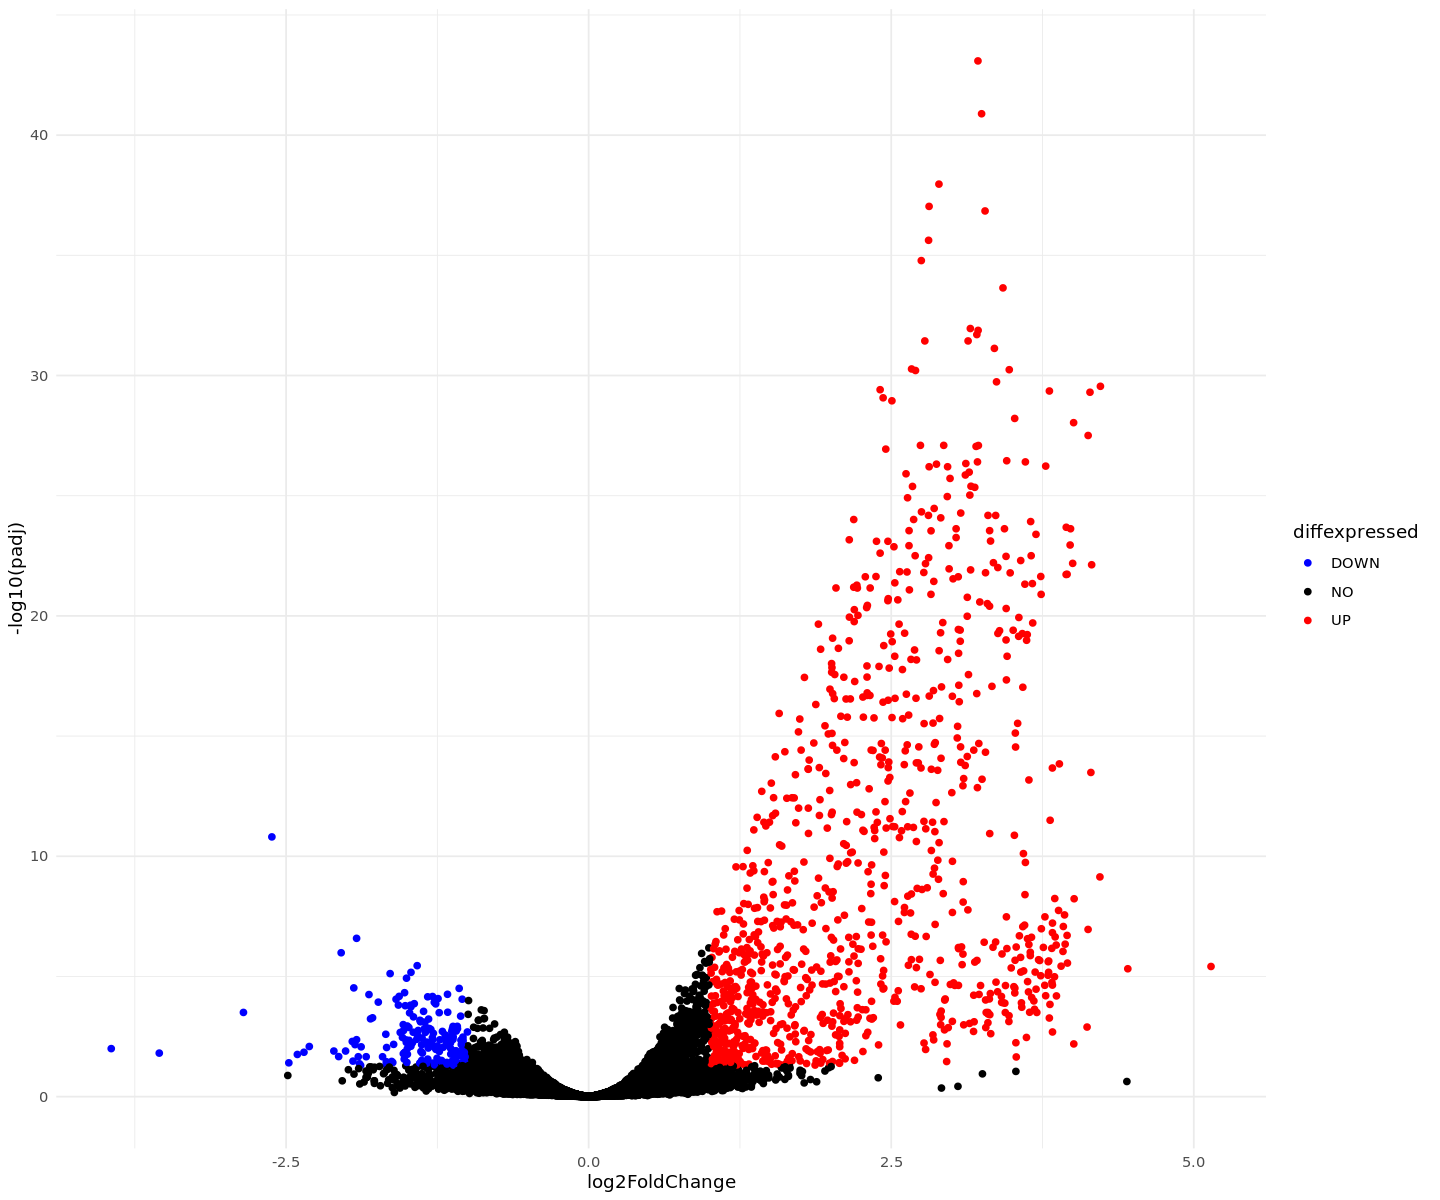

In [37]:
de<-data.frame(subset(res, padj != 0))
dim(de)
de$delabel <- NA
de$symbol <- as.factor(de$symbol)
# add a column of NAs
de$diffexpressed <- "NO"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
de$diffexpressed[de$log2FoldChange > 1 & de$padj < 0.05] <- "UP"
# if log2Foldchange < -1 and pvalue < 0.05, set as "DOWN"
de$diffexpressed[de$log2FoldChange < -1 & de$padj < 0.05] <- "DOWN"
#de$diffexpressed[de$log2FoldChange > 1 & de$padj < 0.05] <- "UP"
#de$delabel[de$log2FoldChange > 5 | -log10(de$padj) > 40] <-"UP"
de$delabel[de$log2FoldChange > 5 | -log10(de$padj) > 30] <- as.character(de$symbol[de$log2FoldChange > 5 | -log10(de$padj) > 30])
de$delabel[(de$log2FoldChange < -2.5) | (de$log2FoldChange < -1 & -log10(de$padj) > 7)] <- as.character(de$symbol[(de$log2FoldChange < -2.5) | (de$log2FoldChange < -1 & -log10(de$padj) > 7)])
plot<-ggplot(data=de, aes(x=log2FoldChange, y=-log10(padj), col=diffexpressed, label=delabel)) + 
    geom_point() + 
    theme_minimal() +
    geom_text(nudge_x = 0.5) +
scale_color_manual(values=c("blue", "black", "red"))
plot
plot2<-ggplot(data=de, aes(x=log2FoldChange, y=-log10(padj), col=diffexpressed)) + 
    geom_point() + 
    theme_minimal()+
scale_color_manual(values=c("blue", "black", "red"))
plot2
ggsave(filename = "deseq2_macrogenonlybleb_outputs/volcanoallDEFC1padj0.05_blebb_dmso.pdf", plot=plot)
ggsave(filename = "deseq2_macrogenonlybleb_outputs/nolab_volcanoallDEFC1padj0.05_blebb_dmso.pdf", plot=plot2)
ggsave(filename = "macrogen_and_celseq_analysisv2_200824/deseq2_macrogen_bleb/macrogen_volcanoallDEFC1padj0.05_blebb_dmso.pdf", plot=plot)
ggsave(filename = "macrogen_and_celseq_analysisv2_200824/deseq2_macrogen_bleb/macrogen_nolab_volcanoallDEFC1padj0.05_blebb_dmso.pdf", plot=plot2)

In [34]:
resSigOrdered <- resSig[order(-resSig$log2FoldChange),]
resSigOrderedDF <- as.data.frame(resSigOrdered)
head(resSigOrderedDF)
write.csv(resSigOrderedDF, file = "deseq2_macrogenonlybleb_outputs/resultsDElogFC1padj0.05_bleb_dmso.csv")
write.csv(resSigOrderedDF, file = "macrogen_and_celseq_analysisv2_200824/deseq2_macrogen_bleb/macrogen_resultsDElogFC1padj0.05_bleb_dmso.csv")
dim(resSigOrderedDF)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol,entrez
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSDARG00000105585,21.54192,5.142317,0.9677828,5.313503,1.075374e-07,3.852103e-06,NA,NA
ENSDARG00000097932,16.92267,4.454798,0.8451804,5.270825,1.358119e-07,4.789305e-06,NA,NA
ENSDARG00000104823,912.70607,4.228468,0.3516296,12.025349,2.614816e-33,2.809963e-30,znf648,101886793
ENSDARG00000002768,59173.09715,4.224387,0.6242202,6.767464,1.310595e-11,7.232361e-10,pvalb2,58028
ENSDARG00000029710,249.42364,4.156055,0.4005367,10.376216,3.181358e-25,7.466319e-23,lrrc30a,552944
ENSDARG00000087258,57.82876,4.149744,0.5103224,8.131612,4.236205e-16,3.263956e-14,ypel2b,561851


[1] 1161    8

## Volcano plot overlaying second experiment

In [35]:
res_expt2<-read.csv("deseq2_trimmed_outputs_CELseq_bleb/resultsDElogFC1DEpadj0.05_bleb_dmso.csv", row.names=1)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



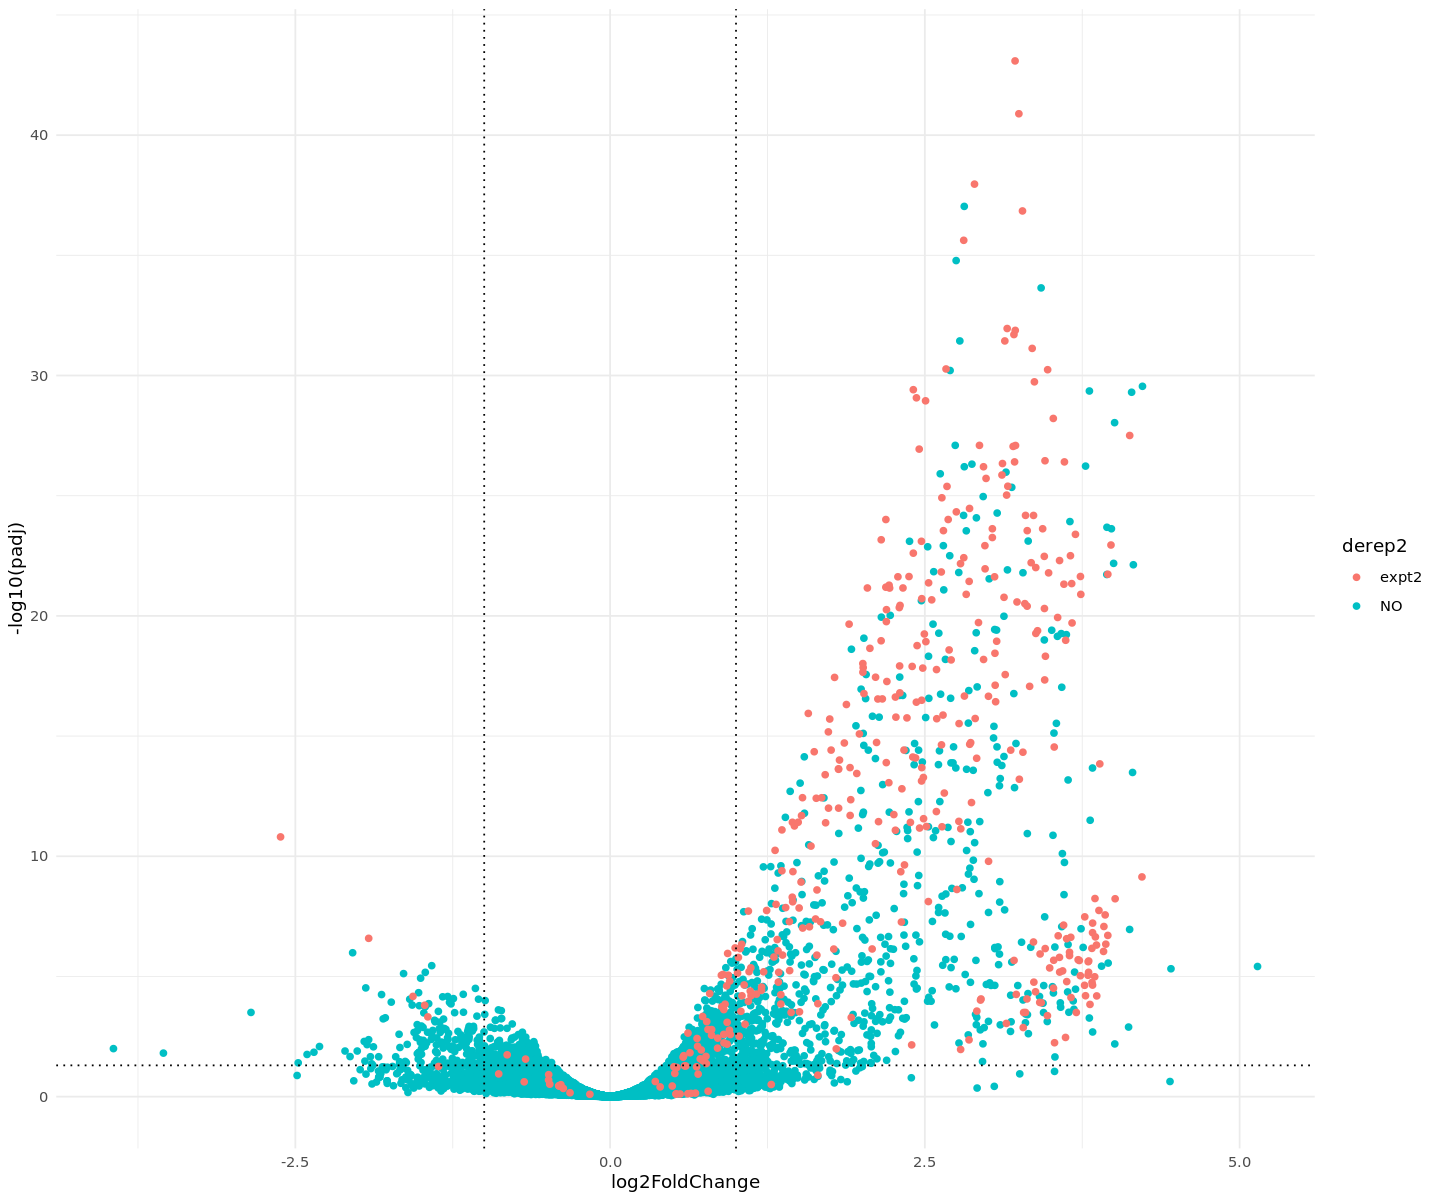

In [36]:
de$derep2 <- "NO"

de$derep2[rownames(de) %in% rownames(res_expt2)] <- "expt2"
de <- de[order(-as.numeric(factor(de$derep2))),]
plotoverlap<-ggplot(data=de, aes(x=log2FoldChange, y=-log10(padj), col=derep2)) + 
    geom_point() + 
    theme_minimal()+
    geom_vline(xintercept=c(-1, 1), col="black", linetype="dotted") +
    geom_hline(yintercept=-log10(0.05), col="black",linetype="dotted")
plotoverlap
ggsave(filename = "deseq2_macrogenonlybleb_outputs/volcanoallDEFC1padj0.05_blebb_dmso_expt2overlap.pdf", plot=plotoverlap)
ggsave(filename = "macrogen_and_celseq_analysisv2_200824/deseq2_macrogen_bleb/macrogen_volcanoallDEFC1padj0.05_blebb_dmso_expt2overlap.pdf", plot=plotoverlap)


In [38]:
save.image(file = "DESeq2_trimmed_macrogen_data_alone_blebb.RData")